In [2]:
!pip install -r requirements.txt


In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-09-12 12:46:32.304270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utils functions

In [4]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    """ This function plots a grid of images and their corresponding masks from given lists of image and mask paths.
    It uses matplotlib for plotting and OpenCV for reading and processing the images.

    Parameters:
    -----------
    rows : int
        The number of rows in the plot grid.

    columns : int
        The number of columns in the plot grid.

    list_img_path : list of str
        A list of paths to the image files to be plotted.

    list_mask_path : list of str
        A list of paths to the mask files to be plotted.

    Returns:
    --------
    None

    Notes:
    ------
    The images are displayed in RGB format, and the masks are overlaid on the images
    with a transparency of 0.4. """
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
    plt.show()
    
def dice_coefficients(y_true, y_pred,smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    
    return(2 * intersection+ smooth) / (union + smooth)

def dice_coefficients_loss(y_true,y_pred,smooth=100):
    return -dice_coefficients(y_true,y_pred,smooth)

''' intersection over union'''
def iou(y_true,y_pred,smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    
    return -iou(y_true_flatten,y_pred_flatten)


## Unet network

In [5]:
def unet(input_size=(256,256,3)):
    """
    This function creates and returns a U-Net model. U-Net is a type of convolutional neural network
    designed for fast and precise segmentation of images. It consists of a contracting (downsampling)
    path and an expansive (upsampling) path, which gives it a U-shaped architecture.

    Parameters:
    -----------
    input_size : tuple of int
        The size of the input images. It is a 3-tuple for (height, width, channels).
        Default is (256, 256, 3).

    Returns:
    --------
    model : keras.models.Model
        The constructed U-Net model.
    """
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    up6 = concatenate(
        [
            Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn5
            ),
            conv4,
        ],
        axis=3,
    )
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate(
        [
            Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn6
            ),
            conv3,
        ],
        axis=3,
    )
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate(
        [
            Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn7
            ),
            conv2,
        ],
        axis=3,
    )
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate(
        [
            Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn8
            ),
            conv1,
        ],
        axis=3,
    )
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [6]:
# setting image size
img_width = 256
img_height = 256

## Loading the image and mask paths

In [7]:
image_filenames_train = []

#creating a list of all files containing the word 'mask'
mask_files = glob('/Users/davidecerpelloni/Desktop/CODE/ML/archive/lgg-mri-segmentation/kaggle_3m/*/*_mask.tif')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask',''))
    
print(image_filenames_train[:10])
print(len(image_filenames_train))

['/Users/davidecerpelloni/Desktop/CODE/ML/archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8.tif', '/Users/davidecerpelloni/Desktop/CODE/ML/archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_9.tif', '/Users/davidecerpelloni/Desktop/CODE/ML/archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_2.tif', '/Users/davidecerpelloni/Desktop/CODE/ML/archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_3.tif', '/Users/davidecerpelloni/Desktop/CODE/ML/archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_20.tif', '/Users/davidecerpelloni/Desktop/CODE/ML/archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_15.tif', '/Users/davidecerpelloni/Desktop/CODE/ML/archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_14.tif', '/Users/davidecerpelloni/Desktop/CODE/ML/archive/lgg-mri-segmentation/ka

## Plotting some images and mask

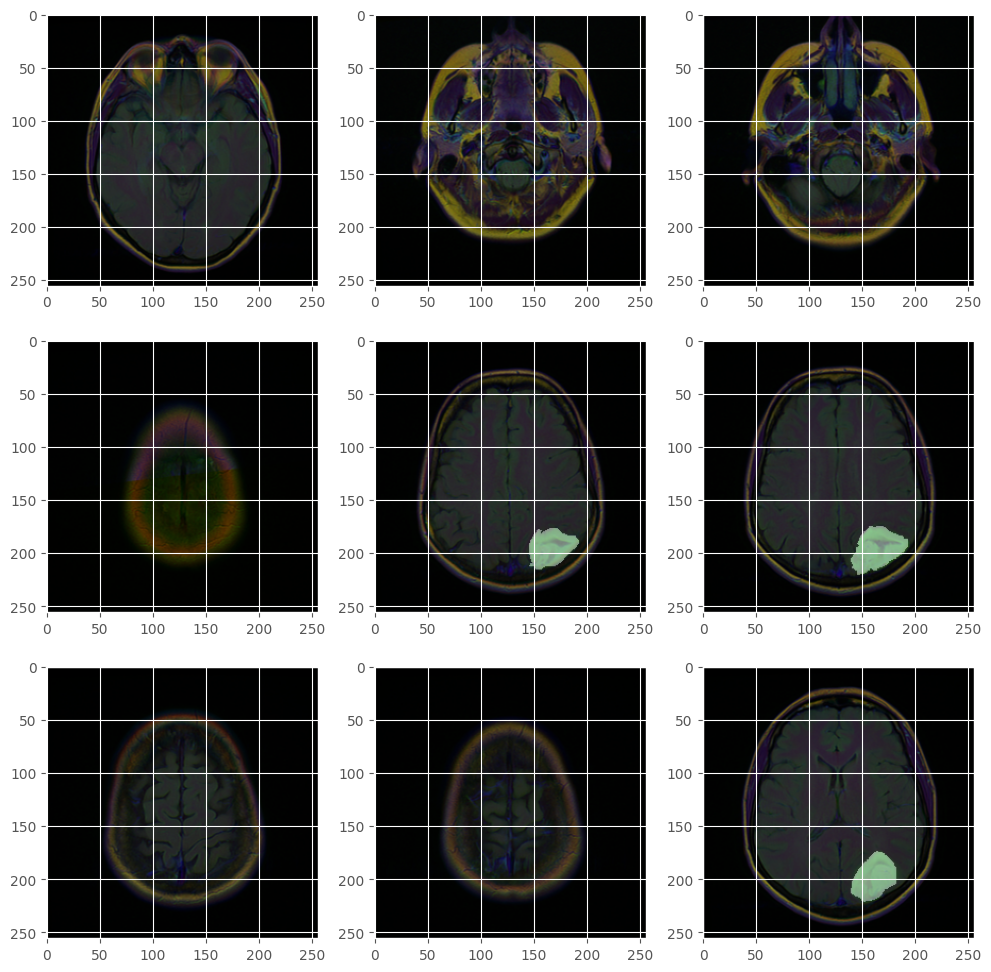

In [8]:
plot_from_img_path(3,3,image_filenames_train, mask_files)

## Create data frame and split data on train, test and validation set

In [9]:
df  = pd.DataFrame(data={'image_filenames_train' : image_filenames_train, 'mask' : mask_files})

df_train, df_test = train_test_split(df, test_size=0.1)

#split val and test
df_train, df_val = train_test_split(df_train,test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)


(2828, 2)
(393, 2)
(708, 2)


## Data generator, data augmentation and adjust data

In [10]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)
        
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [11]:
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [12]:
model = unet()
model.summary

<bound method Model.summary of <Functional name=functional, built=True>>

In [13]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(img_height, img_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(img_height, img_width))
    
model = unet(input_size=(img_height, img_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.keras', verbose=1, save_best_only=True)]

print(train_gen)
print(test_gen)

history = model.fit(train_gen,
                    steps_per_epoch=int(len(df_train) / BATCH_SIZE), 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=int(len(df_val) / BATCH_SIZE)
                    )

<generator object train_generator at 0x149018040>
<generator object train_generator at 0x1490181d0>
Found 2828 validated image filenames.


/Users/davidecerpelloni/Desktop/CODE/ML/.venv/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Found 2828 validated image filenames.
Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 59s/step - binary_accuracy: 0.8249 - dice_coefficients: 0.0884 - iou: 0.0474 - loss: -0.0884 Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02455, saving model to unet.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 5569s 63s/step - binary_accuracy: 0.8260 - dice_coefficients: 0.0889 - iou: 0.0477 - loss: -0.0889 - val_binary_accuracy: 0.9886 - val_dice_coefficients: 0.0245 - val_iou: 0.0125 - val_loss: -0.0245
Epoch 2/100
 1/88 ━━━━━━━━━━━━━━━━━━━━ 29:26 20s/step - binary_accuracy: 0.9913 - dice_coefficients: 0.1138 - iou: 0.0613 - loss: -0.1138

In [ ]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficient']
test_dice_coeff_list = history_post_training['val_dice_coefficient']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

## Load previously trained model

In [ ]:
model = load_model('unet.keras', custom_objects={'dice_coefficient_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficient': dice_coefficients  } )

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(img_height, img_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

## Plotting predicted masks segmentation results from the test image set

In [ ]:
for i in range(20):
    index = np.random.ranint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (img_height, img_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()